In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, EarlyStoppingCallback
from transformers import DataCollatorForSeq2Seq
from huggingface_hub import HfFolder
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import load_dataset, Dataset
from datasets import concatenate_datasets
from transformers import T5Tokenizer, LongT5Model, LongT5Config, LongT5ForConditionalGeneration
from transformers import GenerationConfig
from random import randrange

from hftrim.TokenizerTrimmer import TokenizerTrimmer
from hftrim.ModelTrimmers import T5Trimmer

import evaluate
import nltk
from ast import literal_eval
import pandas as pd
import numpy as np
from nltk.tokenize import sent_tokenize
from collections import Counter
nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/risto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# !pip install nltk

In [3]:
# !pip install evaluate

In [4]:
# !pip install rouge_score

In [5]:
# !pip install py7zr

In [6]:
# !pip install peft

In [7]:
# !pip install transformers --upgrade

source: https://towardsdatascience.com/how-to-adapt-a-multilingual-t5-model-for-a-single-language-b9f94f3d9c90

## model

In [8]:
model_id="agemagician/mlong-t5-tglobal-base"

In [9]:
tokenizer = T5Tokenizer.from_pretrained(model_id)
model = LongT5ForConditionalGeneration.from_pretrained(model_id)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


In [10]:
def msize(m):
    return sum(p.numel() for p in m.parameters())
print(msize(model.shared) / msize(model))   
print(msize(model.lm_head) / msize(model))  

0.3325811738746633
0.3325811738746633


about 33% are embeddings

## data

In [15]:
dataset_id = "riigikogu"
df=pd.read_excel('data/riigikogu/for_summarization_mbart_2048_chunks_summaries.xlsx')
df_train=df[df.split=='train']
df_test=df[df.split=='test']

train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 3516
Test dataset size: 308


In [16]:
train_dataset=train_dataset.filter(lambda example, idx: example['summary'] is not None and example['text'] is not None, with_indices=True)
test_dataset = test_dataset.filter(lambda example, idx: example['summary'] is not None and example['text'] is not None, with_indices=True)

Filter:   0%|          | 0/3516 [00:00<?, ? examples/s]

Filter:   0%|          | 0/308 [00:00<?, ? examples/s]

In [17]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 3516
Test dataset size: 308


## update model vocabulary

In [14]:
texts4vocab=train_dataset['text']+train_dataset['summary']
len(texts4vocab)

7032

In [15]:
cnt_et = Counter()
for text in texts4vocab:
    cnt_et.update(tokenizer.encode(text))
print(len(cnt_et), len(cnt_et)/tokenizer.vocab_size)  

17496 0.06826375341396801


In [16]:
new_tokens = set(range(1000))
for i, (k, v) in enumerate(cnt_et.items()):
    if k not in new_tokens:
        new_tokens.add(k)
for t in range(tokenizer.vocab_size - 100, tokenizer.vocab_size):
    new_tokens.add(t)
print(len(new_tokens))
kept_ids = sorted(new_tokens)

18171


## update model

In [17]:
# model

In [18]:
model.encoder.embed_tokens

Embedding(256384, 768)

In [19]:
model.decoder.embed_tokens

Embedding(256384, 768)

In [20]:
new_size = len(kept_ids)
new_emb = torch.nn.Embedding(new_size, model.shared.embedding_dim)
new_enc_emb=torch.nn.Embedding(new_size, model.encoder.embed_tokens.embedding_dim)
new_dec_emb=torch.nn.Embedding(new_size, model.decoder.embed_tokens.embedding_dim)
new_head = torch.nn.Linear(in_features=model.lm_head.in_features, out_features=new_size, bias=False)
for new_id, old_id in enumerate(kept_ids):
    new_emb.weight.data[new_id] = model.shared.weight.data[old_id]
    new_enc_emb.weight.data[new_id] = model.encoder.embed_tokens.weight.data[old_id]
    new_dec_emb.weight.data[new_id] = model.decoder.embed_tokens.weight.data[old_id]
    new_head.weight.data[new_id] = model.lm_head.weight.data[old_id]
    
model.shared.weight = new_emb.weight
model.encoder.embed_tokens.weight = new_enc_emb.weight
model.decoder.embed_tokens.weight = new_dec_emb.weight
model.lm_head.weight = new_head.weight
model.config.__dict__['vocab_size'] = new_size
model.config.__dict__['_name_or_path'] = 'mlong-t5-tglobal-et-base'

## update tokenizer

In [20]:
# !apt-get update 
# !apt install protobuf-compiler -y

In [21]:
! wget https://raw.githubusercontent.com/google/sentencepiece/master/src/sentencepiece_model.proto
! protoc --python_out=. sentencepiece_model.proto
import sentencepiece.sentencepiece_model_pb2 as spmp
smp = tokenizer.sp_model.serialized_model_proto()
m = spmp.ModelProto()
m.ParseFromString(smp)
print('the loaded model has pieces:', len(m.pieces))
new_pieces = [m.pieces[idx] for idx in kept_ids]
print('the new pieces:', len(new_pieces))
# replace the content of the first 30K pieces
for i, p in enumerate(new_pieces):
    m.pieces[i].piece = p.piece
    m.pieces[i].score = p.score
    m.pieces[i].type = p.type
# drop the remaining pieces
n = len(new_pieces)
for i in range(len(m.pieces) - n):
    m.pieces.pop(len(m.pieces) - 1)
print(len(m.pieces))
with open('mlong-t5-tglobal-et-base/new_sp.model', 'wb') as f:
    f.write(m.SerializeToString())
new_tokenizer = T5Tokenizer('mlong-t5-tglobal-et-base/new_sp.model', extra_ids=0)

--2024-04-23 16:36:57--  https://raw.githubusercontent.com/google/sentencepiece/master/src/sentencepiece_model.proto
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14023 (14K) [text/plain]
Saving to: ‘sentencepiece_model.proto’

sentencepiece_model 100%[===================>]  13.69K  --.-KB/s    in 0.001s  

2024-04-23 16:36:57 (10.9 MB/s) - ‘sentencepiece_model.proto’ saved [14023/14023]

the loaded model has pieces: 256300
the new pieces: 18171
18171


normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


In [22]:
new_tokenizer.save_pretrained('mlong-t5-tglobal-et-base')
model.save_pretrained('mlong-t5-tglobal-et-base')

In [2]:
tokenizer = T5Tokenizer.from_pretrained('mlong-t5-tglobal-et-base')
model = LongT5ForConditionalGeneration.from_pretrained('mlong-t5-tglobal-et-base', max_length=2048)

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


## prep data for training

In [33]:
# The maximum total input sequence length after tokenization.
max_source_length=2048

/home/risto/.local/lib/python3.9/site-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/home/risto/.local/lib/python3.9/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


Map:   0%|          | 0/3824 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Max source length: 2048


In [34]:
max_target_length=512

Map:   0%|          | 0/3824 [00:00<?, ? examples/s]

Max target length: 512


In [37]:
def preprocess_function(sample,padding="max_length"):
    # add prefix to the input for t5
    inputs = ["summarize: " + item for item in sample["text"]]

    # tokenize inputs
    model_inputs = tokenizer(inputs, max_length=max_source_length, padding=padding, truncation=True)

    # Tokenize targets with the `text_target` keyword argument
    labels = tokenizer(text=sample["summary"], max_length=max_target_length, padding=padding, truncation=True)

    # If we are padding here, replace all tokenizer.pad_token_id in the labels by -100 when we want to ignore
    # padding in the loss.
    if padding == "max_length":
        labels["input_ids"] = [
            [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
        ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=["text", "summary"])
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True, remove_columns=["text", "summary"])

Map:   0%|          | 0/3516 [00:00<?, ? examples/s]

Map:   0%|          | 0/308 [00:00<?, ? examples/s]

## evaluator

In [17]:
# Metric
metric = evaluate.load("rouge")

# helper function to postprocess text
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(sent_tokenize(label)) for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    result = {k: round(v * 100, 4) for k, v in result.items()}
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    return result

In [39]:
# we want to ignore tokenizer pad token in the loss
label_pad_token_id = -100
# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id,
    pad_to_multiple_of=8
)

## training 

In [40]:
early_stop = EarlyStoppingCallback(3, 0.0)

In [41]:
# Hugging Face repository id
repository_id = f"{model_id.split('/')[1]}-{dataset_id}"
repository_id

'mlong-t5-tglobal-base-riigikogu'

In [44]:
# Hugging Face repository id
repository_id = "mlong-t5-tglobal-et-base-riigikogu"

# Define training args
training_args = Seq2SeqTrainingArguments(
    output_dir=repository_id,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    predict_with_generate=True,
    fp16=False, # Overflows with fp16
    learning_rate=5e-5,
    num_train_epochs=20,
    # logging & evaluation strategies
    logging_dir=f"{repository_id}/logs",
    logging_strategy="steps",
    logging_steps=500,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    # push to hub parameters
    report_to="tensorboard",
    push_to_hub=False,
    hub_strategy="every_save",
    hub_model_id=repository_id,
    hub_token=HfFolder.get_token()
)

# Create Trainer instance
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stop]
)

/home/risto/.local/lib/python3.9/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [45]:
# Start training
trainer.train()

/home/risto/.local/lib/python3.9/site-packages/transformers/modeling_utils.py:896: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,2.164000,1.604335,32.173000,14.141600,26.113400,30.245000,110.642857
2,1.898700,1.539341,33.640900,14.952500,27.055900,31.663000,107.860390
3,1.762000,1.499942,34.929600,15.387700,27.709700,32.960800,115.376623
4,1.663600,1.485179,35.673100,15.975300,28.503300,33.658300,107.126623
5,1.580200,1.468613,35.302900,15.818200,28.174300,33.260700,117.409091
6,1.524300,1.464044,35.607900,15.949600,28.233900,33.446300,116.892857
7,1.441700,1.463820,35.907100,15.920900,28.413800,33.682200,111.048701
8,1.394600,1.472137,36.059400,16.427900,28.581200,33.758700,115.168831
9,1.343500,1.462306,35.918900,15.974900,28.353200,33.530400,115.551948
10,1.329900,1.463844,36.098700,16.466200,28.993400,33.947600,112.795455


/home/risto/.local/lib/python3.9/site-packages/transformers/modeling_utils.py:896: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/risto/.local/lib/python3.9/site-packages/transformers/modeling_utils.py:896: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/risto/.local/lib/python3.9/site-packages/transformers/modeling_utils.py:896: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/risto/.local/lib/python3.9/site-packages/transformers/modeling_utils.py:896: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/risto/.local/lib/python3.9/site-packages/transformers/modeling_utils.py:896: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/risto/.local/lib/python3

TrainOutput(global_step=21096, training_loss=1.5620416674507265, metrics={'train_runtime': 18449.8239, 'train_samples_per_second': 3.811, 'train_steps_per_second': 1.906, 'total_flos': 1.100125970670551e+17, 'train_loss': 1.5620416674507265, 'epoch': 12.0})

## calculate final metrics

In [12]:
model_id='mlong-t5-tglobal-et-base-riigikogu/checkpoint-15822/'
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)
model=model.to('cuda')

In [25]:
def calc_texts_labels_metrics(texts, summaries, max_input_length=2048, max_output_length=512, batch_size = 10, device='cuda'):
    true_labels=tokenizer(
        summaries, return_tensors="pt",padding="max_length", truncation=True, max_length=max_input_length
    ).input_ids.cpu()
    input_ids = tokenizer(
        texts, return_tensors="pt", padding="max_length", truncation=True, max_length=max_input_length
    ).input_ids  
    
    predictions = []
    for i in range(0, input_ids.size(0), batch_size):
        batch_input_ids = input_ids[i:i + batch_size].to(device)
        batch_outputs = model.generate(input_ids=batch_input_ids, max_length=max_output_length)
        predictions.extend(batch_outputs.cpu().detach().numpy())
    max_length = max(len(p) for p in predictions)
    padded_predictions = [np.pad(p, (0, max_length - len(p)), mode='constant') for p in predictions]
    outputs = torch.tensor(padded_predictions)
    # outputs = torch.tensor(predictions)
    eval_preds = (outputs, true_labels.cpu())
    metrics = compute_metrics(eval_preds)
    return metrics

In [59]:
eval_metrics=calc_texts_labels_metrics(df_test.text.tolist(), df_test.summary.tolist())

/home/risto/.local/lib/python3.9/site-packages/transformers/modeling_utils.py:896: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [60]:
eval_metrics

{'rouge1': 36.1651,
 'rouge2': 15.9668,
 'rougeL': 28.339,
 'rougeLsum': 33.767,
 'gen_len': 113.45454545454545}

## example usage

In [11]:
def summarize(text, model, tokenizer, max_new_tokens=512):
    input_ids = tokenizer(
         text, return_tensors="pt"
    ).input_ids  # Batch size 1
    outputs = model.generate(input_ids=input_ids.to('cuda'), max_new_tokens=max_new_tokens)
    print(tokenizer.decode(outputs[0], skip_special_tokens=True))

In [62]:
summarize(df_test.text.tolist()[0], model, tokenizer)

- Sven Sester annab ülevaate riigieelarve seaduse eelnõu ettevalmistamisest teiseks lugemiseks.
- Eelnõu eesmärk on Euroopa Nõukogu direktiiv 2011/85/EL liikmesriikide eelarveraamistiku miinimumnõuete kohta üle võtta.
- Muudatusettepanekud tehti järgmisel istungil: piirang keskvalitsuse juriidilise isiku asutamisel, ümberkorraldamisel ja lõpetamisel, tasakaalureeglid, kompenseerimismehhanismi leevendamine, eelarvepositsiooni püstitamine, eelarvepositsiooni eesmärgi püstitamine.


In [63]:
summarize("summarize: Studies have shown that owning a dog is good for you", model, tokenizer)

- Studies are showd, owning a dog is good to you - Studies are showd, owning a dog is good to you - Studies are showd, owning a dog is good to you - Studies are showd, owning a dog is good to you - Studies are showd, owning a dog is good to you - Studies are showd, owning a dog is good to you - Studies are showd, owning a dog is good to you - Studies are showd, owning a dog is good to you - Studies are showd, owning a dog is good to you - Studies are showd, owning a dog is good to you - Studies are showd, owning a dog is good to you - Studies are showd, owning a dog is good to you - Studies are showd, owning a dog is good to you - Studies are showd, owning a dog is good to you - Studies are showd, owning a dog is good to you - Studies are showd, owning a dog is good to you - Studies are showd, owning a dog is good to you - Studies are showd, owning a dog is good to you - Studies are showd, owning a dog is good to you - Studies are showd, owning a dog is good to you - Studies are showd,

In [64]:
summarize(df_test.text.tolist()[1], model, tokenizer)

- Sven Sester selgitab Eesti Panga seaduse muutmise seaduses esitatud muudatusettepanekuid ja muudatusi
- Muudatusettepanek nr 17, 19, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 51, 52, 53, 54, 55, 56, 57, 58, 59, 51, 52, 53, 54, 55, 56, 57, 58, 59, 51, 52, 53, 54, 55, 56, 57, 58, 59, 51, 52, 53, 54, 55, 56, 57, 58, 59, 51, 52, 53, 54, 55, 56, 57, 58, 59, 51, 52, 53, 54, 55, 56, 57, 58, 59, 51, 52, 53, 54, 55, 56, 57, 58, 59, 51, 52, 53, 54, 55, 56, 57, 58, 59, 51, 52, 53, 54, 55, 56, 57, 58, 59, 51


In [65]:
summarize(df_test.text.tolist()[2], model, tokenizer)

- Sven Sester soovitab riigi eelarvestrateegia tuua Riigikogus arutusele, et muuta iga-aastase eelarve seaduse seletuskirja õiguslikku tähendust ja kirjeldada otsustusõigus riigi jaoks oluliste pikaajaliste eesmärkide kehtestamisel.
- Komisjon käsitles töötuskindlustusmakse määrade kehtestamise regulatsiooni ja Euroopa Keskpanga arvamust eelnõu kohta.
- Rahanduskomisjon koostas muudatusettepanekuid riigi eelarvestrateegia süsteemi regulatsioonide täiendamiseks ning otsustas võtta eelnõu teiseks lugemiseks täiskogu istungi päevakorda 15. jaanuaril.


In [66]:
summarize(df_test.text.tolist()[3], model, tokenizer)

- Jaak Allik küsib, millise sisu annab eelnõu lausele valdkonna arengukava esitamise enne kinnitamist Riigikogule arutamiseks.
- Kalev Kotkas küsib, kuidas tasakaalus olevad tulud ja kulud saavad olla tasakaalus ning kuidas nende vahe saab olla tasakaalus.
- Andres Herkel küsib, miks tuuakse tooreid eelnõusid, mis ei ole piisavalt selged ning kuidas reageeritakse Riigikontrollile.


In [67]:
text="""Veel veebruaris oli Soome kõige populaarsem partei Koonderakond, kuid kaotas märtsis selle tiitli SDP-le. Märtsis langes peaministripartei  toetus ühe protsendi võrra ning Koonderakonna toetus on nüüd 20,6 protsenti.
SDP suurendas toetust naiste ja noorte hulgas. Märtsis tõusis SDP toetus 1,9 protsenti ning erakonna toetus on nüüd 21,7 protsenti. 
Koonderakonna kannul on Põlissoomlased, rahandusminister Riikka Purra kodupartei toetus on 17,4 protsenti."""
summarize(text, model, tokenizer)

- Koonderakond kaotas märtsis tiidi SDP-le, mis suurendas toetust naiste ja noorte hulgas.
- Koonderakonna toetus suurenes naiste ja noorte hulgas, kuid erakonna toetus on nüüd 21,7 protsenti.
- Koonderakonna kannul on Põlissoomlased, rahandusminister Riikka Purra kodupartei toetus on 17,4 protsenti.


## analyze test data summaries

In [19]:
def summarize(text, model, tokenizer, max_new_tokens=512, device='cuda'):
    input_ids = tokenizer(
         text, return_tensors="pt"
    ).input_ids  # Batch size 1
    outputs = model.generate(input_ids=input_ids.to(device), max_new_tokens=max_new_tokens)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [20]:
test_summaries=[]
for text in df_test.text.tolist():
    summary_=summarize(text, model, tokenizer)
    test_summaries.append(summary_)

In [21]:
len(test_summaries)

308

In [24]:
df_test['model_summaries']=test_summaries

/tmp/ipykernel_44012/2775572515.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['model_summaries']=test_summaries


In [36]:
df_test['model_summaries_ntoks']=df_test['model_summaries'].apply(lambda x: tokenizer(x, return_tensors="pt").input_ids.shape[1])

/tmp/ipykernel_44012/2492651422.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['model_summaries_ntoks']=df_test['model_summaries'].apply(lambda x: tokenizer(x, return_tensors="pt").input_ids.shape[1])


<AxesSubplot:>

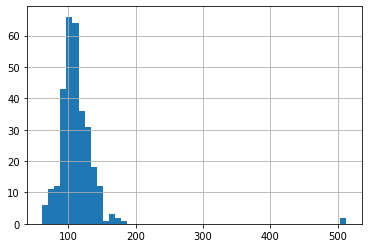

In [38]:
df_test['model_summaries_ntoks'].hist(bins=50)

In [41]:
#some are very long
df_test[df_test['model_summaries_ntoks']>400].model_summaries[47]

'- Sven Sester selgitab Eesti Panga seaduse muutmise seaduses esitatud muudatusettepanekuid ja muudatusi\n- Muudatusettepanek nr 17, 19, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 51, 52, 53, 54, 55, 56, 57, 58, 59, 51, 52, 53, 54, 55, 56, 57, 58, 59, 51, 52, 53, 54, 55, 56, 57, 58, 59, 51, 52, 53, 54, 55, 56, 57, 58, 59, 51, 52, 53, 54, 55, 56, 57, 58, 59, 51, 52, 53, 54, 55, 56, 57, 58, 59, 51, 52, 53, 54, 55, 56, 57, 58, 59, 51, 52, 53, 54, 55, 56, 57, 58, 59, 51, 52, 53, 54, 55, 56, 57, 58, 59, 51'

In [43]:
df_test.text[47]

' \n Sven Sester: Seaduses on  Eesti Panga hinnangu andmise aega reguleeritud eelnõu §-s 82 toodud Eesti Panga seaduse muutmise seaduses. Muudatusettepanek nr 17. Rahastamisotsuste lisamine arengukavasse ei taga, et kõik kuluotsused tehakse samaaegselt, raha puudutavad otsused on koondunud riigi eelarvestrateegia ja eelarve protsessi, kus tasakaalustatakse arengukavade vajadused ning riigi tulud ja võimalused. Arengukavad on pikema perspektiiviga kui riigi eelarvestrateegia. Neljast aastast pikemad rahastamismahud on küsitavad. Muudatusettepanek nr 19. Muudatus süvendaks valitsemisalakesksust riigi tegevuse suunamisel, ühiskonnas soovitud muudatuste saavutamist mõjutavad tegevused ei ole aga reeglina vaid ühes  valitsemisalas. Valdkonna ulatuse defineerimine valitsemisalapõhiselt on liialt piirav. Näiteks  Majandus- ja Kommunikatsiooniministeeriumi valdkonnad on majandus, energeetika, transport ja infoühiskond, Sotsiaalministeeriumi omad aga rahvastiku- ja perepoliitika, sotsiaalne tur

In [42]:
df_test[df_test['model_summaries_ntoks']>400].model_summaries[56]

'- Aseesimees Jüri Ratas alustab hääletuse ettevalmistamist ja paneb hääletusele muudatusettepanekud nr 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,'

In [44]:
df_test.text[56]

' \n Aseesimees Jüri Ratas: Alustame hääletuse ettevalmistamist. Panen hääletusele muudatusettepaneku nr 47. Palun võtta seisukoht ja hääletada! Hääletustulemused   Poolt hääletas 26 Riigikogu liiget, vastu 39, 1 erapooletu. Ettepanek ei leidnud toetust. Muudatusettepanek nr 48 on juhtivkomisjoni esitatud. Muudatusettepanek nr 49 on Sotsiaaldemokraatliku Erakonna fraktsiooni esitatud, juhtivkomisjon ei ole seda arvestanud. Muudatusettepanekud nr 50, 51, 52, 53 ja 54 on juhtivkomisjoni esitatud. Muudatusettepanek nr 55 on Sotsiaaldemokraatliku Erakonna fraktsiooni esitatud, juhtivkomisjon ei ole seda arvestanud. Muudatusettepanek nr 56 on Sotsiaaldemokraatliku Erakonna fraktsiooni esitatud, juhtivkomisjoni seisukoht: jätta arvestamata. Muudatusettepanek nr 57 on Sotsiaaldemokraatliku Erakonna fraktsiooni esitatud, juhtivkomisjoni seisukoht: jätta arvestamata. Muudatusettepanek nr 58 on Sotsiaaldemokraatliku Erakonna fraktsiooni esitatud, juhtivkomisjoni seisukoht: jätta arvestamata. Eik

## quantized version

In [10]:
from optimum.onnxruntime import ORTModelForSeq2SeqLM

In [31]:
model_id = "mlong-t5-tglobal-et-base-onnx-quantized"
model = ORTModelForSeq2SeqLM.from_pretrained(model_id, use_cache=False)

Generation config file not found, using a generation config created from the model config.


In [32]:
def summarize(text, model, tokenizer, max_new_tokens=512, device='cpu'):
    input_ids = tokenizer(
         text, return_tensors="pt"
    ).input_ids  # Batch size 1
    outputs = model.generate(input_ids=input_ids.to(device), max_new_tokens=max_new_tokens)
    print(tokenizer.decode(outputs[0], skip_special_tokens=True))

In [33]:
text="""Veel veebruaris oli Soome kõige populaarsem partei Koonderakond, kuid kaotas märtsis selle tiitli SDP-le. Märtsis langes peaministripartei  toetus ühe protsendi võrra ning Koonderakonna toetus on nüüd 20,6 protsenti.
SDP suurendas toetust naiste ja noorte hulgas. Märtsis tõusis SDP toetus 1,9 protsenti ning erakonna toetus on nüüd 21,7 protsenti.
Koonderakonna kannul on Põlissoomlased, rahandusminister Riikka Purra kodupartei toetus on 17,4 protsenti."""
summarize(text, model, tokenizer)

- Soome populaarse partei Koonderakond kaotas märtsis 10,6 protsenti
- Koonderakonna toetus suurenes naiste ja noorte hulgas
- Põlissoomlased ja rahandusminister Riikka Purra kodupartei toetus on 17,4 protsenti.


In [34]:
eval_metrics_onnx=calc_texts_labels_metrics(df_test.text.tolist(), df_test.summary.tolist(), device='cpu')

/tmp/ipykernel_29815/3614468802.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  outputs = torch.tensor(padded_predictions)


In [36]:
eval_metrics_onnx

{'rouge1': 31.4808,
 'rouge2': 13.2597,
 'rougeL': 24.6276,
 'rougeLsum': 29.6002,
 'gen_len': 111.2012987012987}

In [35]:
# !unzip mlong-t5-tglobal-et-base-onnx-quantized-20240426T063555Z-001.zip

In [37]:
summarize(df_test.text.tolist()[0], model, tokenizer)

- Sven Sester annab ülevaate riigieelarve seaduse eelnõud ettevalmistamisest teiseks lugemiseks
- Eelnõu on kanab numbrit 513, Rahanduskomisjon arutas eelnõu 19. novembril ja 17. detsembril ning tänavu 13. ja 14. jaanuaril.
- Komisjoni ettepanekud tehti järgmiselt:
- Maksustati piirang keskvalitsuse juriidilise isiku asutamisel, ümberkorraldamisel ja lõpetamisel ning muutti tasakaalureegli asemel.


In [38]:
summarize(df_test.text.tolist()[1], model, tokenizer)

- Sven Sester selgitab, et Eesti Panga hinnangu andmise aeg reguleeritud eelnõu §s 82 toodud Eesti Panga seaduse muutmise seaduses.
- Muudatusettepanek nr 17, 19, 20, 23, 24, 26, 27, 33, Kohalikud omavalitsused, Finantsdistsipliini meetmed, stabiliseerimisreserv, töötuskindlustusmakse määr, loomakaitseseaduse § 64 lõike 6 sisu.
- Põhiseaduskomisjon viitas kahele eelnõu probleemile: Riigikogu rolli vähenemine, põhiseaduslike institutsioonide erisused eelarve menetluses ning eelarveprobleemid lahendamine.


In [41]:
summarize(df_test.text.tolist()[2], model, tokenizer)

- Sven Sester: Riigikogu peaks muutma riigieelarvega eraldatava raha kasutamise sisulisi ja mõõdetavaid eesmärke, et tuua riiklikult tähtsa küsimusena Riigikogus arutusele
- Aruandlus ei ole piisavalt informiivne ega aita riigieelarve kulutuste tulemuslikkuse parandamisele
- Baasseadusega planeeritud muudatused ei mõjuta töötukassa autonoomiat ega sotsiaalpartnerluse põhimõtteid


In [39]:
summarize("summarize: Studies have shown that owning a dog is good for you", model, tokenizer)

- Studies are stize to a dog is a dog to a dog
- Studies are show a dog is a dod to a dog
- Studies are show a dog is a dog to a dog to a dog
- Studies are show a dod is a dod to a dog is a dod to a dog


In [40]:
summarize(df_test.text.tolist()[3], model, tokenizer)

- Jaak Allik esitab küsimuse esitamise juurde, alustatakse küsimuste esitamisega.
- Jaak Allik küsib, millise sisu annabte eelnõu lausele, et valdkonna arengukava esitatakse enne kinnitamist Riigikogule arutamiseks.
- Kalev Kotkas küsib, kuidas tasakaalus on eelarveaasta põhitegevuse tulud ja kulud ning kuidas neid saab olla tasakaalus.
